## Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *

## Read and preprocess data


In [4]:
import csv
from datetime import datetime
import os

def load_data(file_path):
    data_dict = dict()

    with open(file_path) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['Numéro du groupe'] != '':
                heures, minutes, _ = map(int, row['TransitTime'].split(':')) 
                total_minutes = heures * 60 + minutes
                data_dict[int(float(row['Numéro du groupe']))] = (
                    int(float(row['Femmes'])),
                    int(float(row['Hommes'])),
                    int(float(row['WCHR'])),
                    total_minutes
                )

    return data_dict

# Load data for each file

file_names = ["5Nov.csv", "7Nov.csv", "22Oct.csv", "24Oct.csv", "23Oct.csv", "30Oct.csv", "DataSeating 2024.csv"]
data_directory = 'data'
# for eachy dictionary : dict[Numéro du groupe : (Femmes, Hommes, WCHR, TransitTime)]
Nov5, Nov7, Oct22, Oct24, Oct23, Oct30, Date0 = [load_data(os.path.join(data_directory, file)) for file in file_names]

Example of how we access data

In [5]:
Nov5[1][0] # Number of women in group 1 on November 5th

1

Transforming data to access each passenger's Id

First we solved the problem for November 5th, then we'll have to automate it

In [6]:
Passengers = {}
j = 1

for group_num, data in Nov5.items():
    weights = {'Femmes': 70, 'Hommes': 85, 'WCHR': 100}  # Weight per passenger
    
    # Extracting data
    femmes, hommes, wchr, total_minutes = data
    
    # Enumerating passengers
    for _ in range(femmes + hommes + wchr):
        if femmes > 0:
            weight = weights['Femmes']  
            Passengers[j] = {'gender': 'Femmes', 'group': group_num, 'weight': weight, 'connection_time': total_minutes}
            femmes -= 1
        elif hommes > 0:
            weight = weights['Hommes']
            Passengers[j] = {'gender': 'Hommes', 'group': group_num, 'weight': weight, 'connection_time': total_minutes}
            hommes -= 1
        else:
            weight = weights['WCHR']
            Passengers[j] = {'gender': 'WCHR', 'group': group_num, 'weight': weight, 'connection_time': total_minutes}
            wchr -= 1
        j += 1

print(Passengers)

{1: {'gender': 'Femmes', 'group': 1, 'weight': 70, 'connection_time': 0}, 2: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 3: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 4: {'gender': 'Hommes', 'group': 2, 'weight': 85, 'connection_time': 60}, 5: {'gender': 'Femmes', 'group': 3, 'weight': 70, 'connection_time': 165}, 6: {'gender': 'Hommes', 'group': 3, 'weight': 85, 'connection_time': 165}, 7: {'gender': 'Femmes', 'group': 4, 'weight': 70, 'connection_time': 0}, 8: {'gender': 'Hommes', 'group': 4, 'weight': 85, 'connection_time': 0}, 9: {'gender': 'WCHR', 'group': 4, 'weight': 100, 'connection_time': 0}, 10: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 11: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 12: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 13: {'gender': 'Femmes', 'group': 6, 'weight': 70, 'connection_time': 0}, 14: {'gender': 'Hommes', 'group': 6, 'weig

In [7]:
Passengers[1] # Characteristic of passenger 1 of November 5

{'gender': 'Femmes', 'group': 1, 'weight': 70, 'connection_time': 0}

## Static model

In [8]:
ranks = 29 #number of rows in the aircraft
n = 90 #number of passengers - TO BE CHANGED
ns=7*ranks #number of seats

def modele_statique():
    m=Model('statique') # Model initialization
    
    # -- Adding variables  --
    # Sij : dict[(int, int) : Var] : Associate passenger i with seat j
    S = {(i,j) : m.addVar(vtype = GRB.BINARY, name = f'j{i}') for i in range(1, n+1) for j in range (1, ns+1)}

    # -- Adding constraints  --
    
    # Max. 1 seat per passenger
    for j in range (1, ns+1):
        m.addConstr(quicksum(S[(i,j)] for i in range (1, n+1)) <=1, name="PassengerMax")

    #Each passenger has one and only one seat
    for i in range (1, n+1):
        m.addConstr(quicksum(S[(i,j)] for j in range (1, ns+1)) == 1, name="SeatMax")
        
    #The central aisle is left free   
    for i in range (1, n+1):
        for j in range (1, ns+1):
            if j%7==4 : 
                m.addConstr(S[(i, j)] == 0)
                
   #Barycenters
    x_g = LinExpr()
    y_g = LinExpr()

    total_weight = quicksum(Passengers[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        for j in range(1, ns + 1):
            weight_ij = Passengers[i]['weight'] / total_weight
            if (j % 7 == 0):
                x_g += (1 * S[i, j] * weight_ij)
                y_g += (1 * S[i, j] * weight_ij)
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += ((j % 21) * S[i, j] * weight_ij)
    

    m.addConstr(x_g >= 3)  
    m.addConstr(x_g <= 5)  
    m.addConstr(y_g >= 13)  
    m.addConstr(y_g <= 17)

    return m, S

Fonctions objectifs

In [9]:
m,S=modele_statique()

#Les passagers en transit sont placés à l'avant de l'avion

def obj_transit():
    T= {} 
    
    
    for passenger in Passengers:
        if Passengers[passenger]['connection_time'] >0:   #passager en transit
            T[passenger]=Passengers[passenger]['connection_time']

    #T=sorted(T.items(), key=lambda item:item[1], reverse=True)
    P=list(T.keys())  #retourne la liste des identifiants des passagers en transit
    

    f=0
    for k in range (len(P)):
        for j in range (1, ns+1):
            q=(j-1)//7
            f+= S[(P[k],j)] * (1/T[P[k]]) * q
            

    return f

#m.setObjective(obj_transit(), GRB.MINIMIZE)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-06


In [10]:
def obj_dist(alpha):
    
    distance = 0

    # Calculating distance for each group
    for i in range(1, n + 1):
        for j in range(i + 1, n + 1):
            # Check if passengers are from the same group
            if Passengers[i]['group'] == Passengers[j]['group']:  
                # Calculating coordinates x and y
                
                if ( i %7 ==0):
                    x_i = 7  
                    y_i = (i // 7) + 1
                    x_j = 7              	
                    y_j = (j // 7) + 1
                else:
                    x_i = (i % 7)  
                    y_i = (i // 7) + 1
                    x_j = (j % 7)  
                    y_j = (j // 7) + 1

                
                # Calculating distance 
                distance_x = abs(x_i - x_j)**2
                distance_y = abs(y_i - y_j)**2
                
                # Weighting more for distance in x
                weighted_distance = alpha * distance_x + (1-alpha)* distance_y
                
                distance += weighted_distance
                
    return distance

alpha = 0.8
m.setObjective(obj_dist(alpha),GRB.MINIMIZE)

In [11]:
# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0 # mode muet

# -- Mise à jour du modèle  --
m.update() 

# -- Affichage en mode texte du PL --
display(m)

<gurobi.Model MIP instance statique: 2907 constrs, 18270 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [12]:
# -- Résolution --
m.optimize()

# -- Affichage de la solution --
print("Les places dans l'avion sont les suivantes :", [(i,j) for i in range(1,n+1) for j in range (1,ns+1) if S[(i,j)].x])

Les places dans l'avion sont les suivantes : [(1, 203), (2, 162), (3, 114), (4, 33), (5, 14), (6, 97), (7, 190), (8, 82), (9, 202), (10, 10), (11, 100), (12, 121), (13, 61), (14, 145), (15, 40), (16, 125), (17, 113), (18, 12), (19, 1), (20, 143), (21, 142), (22, 157), (23, 51), (24, 181), (25, 139), (26, 54), (27, 156), (28, 198), (29, 50), (30, 79), (31, 31), (32, 19), (33, 188), (34, 52), (35, 17), (36, 185), (37, 120), (38, 163), (39, 73), (40, 13), (41, 7), (42, 164), (43, 41), (44, 176), (45, 134), (46, 58), (47, 42), (48, 16), (49, 146), (50, 9), (51, 71), (52, 141), (53, 64), (54, 197), (55, 183), (56, 155), (57, 166), (58, 8), (59, 135), (60, 20), (61, 92), (62, 72), (63, 122), (64, 78), (65, 115), (66, 104), (67, 187), (68, 201), (69, 99), (70, 136), (71, 38), (72, 57), (73, 29), (74, 80), (75, 15), (76, 103), (77, 124), (78, 37), (79, 83), (80, 93), (81, 178), (82, 62), (83, 184), (84, 36), (85, 76), (86, 22), (87, 101), (88, 94), (89, 167), (90, 59)]


In [13]:
# Creating a variable called seats containing only the j coordinates
seats = [j for i in range(1, n + 1) for j in range(1, ns + 1) if S[(i, j)].x]

def seat_coordinates(seat):


    coordinates = []
    for j in range(0,  len(seats)):
        #print(seats[0]%7)
        if (seats[j] % 7 == 0):
            x = 7
            y = (seat[j] // 7) #%29
        else:
            x = seat[j] % 7
            y = (seat[j] // 7)+ 1

        coordinates.append((x, y))

    return coordinates


seat_coords = seat_coordinates(seats)
x_coords = [coord[0] for coord in seat_coords]  
y_coords = [coord[1] for coord in seat_coords]

Sample seating arrangement data obtained from the optimization model

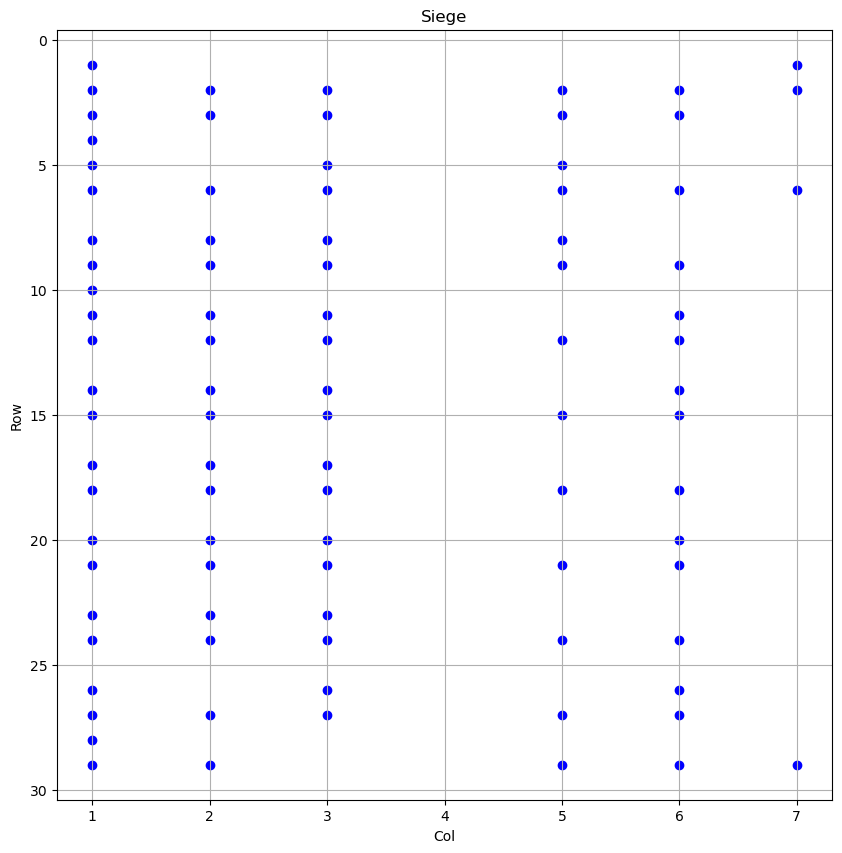

In [16]:
plt.figure(figsize=(10, 10))  
plt.scatter(x_coords, y_coords, color='blue')  
plt.xlabel('Col')  # Rótul
plt.ylabel('Row') 
plt.title('Siege')  
plt.grid(True)  
plt.gca().invert_yaxis()  
plt.show()  